In [1]:
%cd ../src/

/home/folgert/projects/nnfit/src


In [2]:
%run nets.py
%run simulation.py
%run dataset.py
%run utils.py
%run fit.py

In [3]:
import torch

In [4]:
def load_model(n_agents, varying_start_value, timesteps, distortion):
    start = "vstart" if varying_start_value else "fstart"
    distortion = "_distortion" if distortion else ""
    path = f'../results/{n_agents}_{start}_{timesteps}{distortion}.pt'
    model = ResNet(1)
    model.load_state_dict(torch.load(path))
    return model

def get_bins(timesteps, min_bin_length=4):
    bins = {}
    maxlen = np.ceil(timesteps / min_bin_length)
    for i in range(1, int(maxlen + 1)):
        bins[i] = int(np.ceil(timesteps / i))
    bins = np.array(sorted(set(bins.values())))
    return bins

In [225]:
import collections
import numpy as np
import pandas as pd
import tqdm

n_agents, timesteps, varying_start_value, distortion = 10000, 200, False, False
model = load_model(n_agents, varying_start_value, timesteps, distortion)
model.eval()

device = torch.device("cuda")
model.to(device)

bins = get_bins(timesteps)

n_reps = 1000

selection_values = np.concatenate(
    ([0], np.exp(np.linspace(np.log(0.001), np.log(1), timesteps - 1))))

nn_results, fit_results = [], []

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    for i, selection in enumerate(selection_values):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)
        for bin_size in bins:
            binned_data = apply_binning(data, bin_size, n_agents)
            data_dict[bin_size].append((selection, torch.FloatTensor(binned_data)))
            
            # Perform the FIT test
            fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
            fit.update({
                "selection": selection,
                "bin": bin_size,
            })
            fit_results.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(data)).cpu().numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nn_results.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i]
                })

100%|██████████| 1000/1000 [58:56<00:00,  3.54s/it]


In [226]:
nn_df = pd.DataFrame(nn_results)
fit_df = pd.DataFrame(fit_results)

In [227]:
nn_df['FP'] = (nn_df['selection'] == 0) & (nn_df['pred'] == True)
nn_df['FN'] = (nn_df['selection'] > 0) & (nn_df['pred'] != True)
nn_df['F'] = nn_df["FN"] | nn_df["FP"]
nn_df.head()

,selection,bin,pred,prob,FP,FN,F
0,0.000000,4,False,0.088520,False,False,False
1,0.001000,4,False,0.134602,False,True,True
2,0.001036,4,False,0.109236,False,True,True
3,0.001072,4,False,0.102319,False,True,True
4,0.001110,4,False,0.135172,False,True,True


In [228]:
fit_df['FP'] = (fit_df['selection'] == 0) & (fit_df['Tp'] < 0.05)
fit_df['FN'] = (fit_df['selection'] > 0) & (fit_df['Tp'] > 0.05)
fit_df['F'] = fit_df["FN"] | fit_df["FP"]
fit_df['pred'] = fit_df['Tp'] < 0.05
fit_df.head()

,T,Tp,W,Wp,selection,bin,FP,FN,F,pred
0,-1.758234,0.220783,0.913638,0.430331,0.0,4,False,False,False,False
1,-1.716848,0.184509,0.933768,0.616716,0.0,5,False,False,False,False
2,-1.653494,0.173574,0.833393,0.147472,0.0,6,False,False,False,False
3,-1.767842,0.137329,0.836883,0.122814,0.0,7,False,False,False,False
4,-2.021087,0.089765,0.921695,0.482673,0.0,8,False,False,False,False


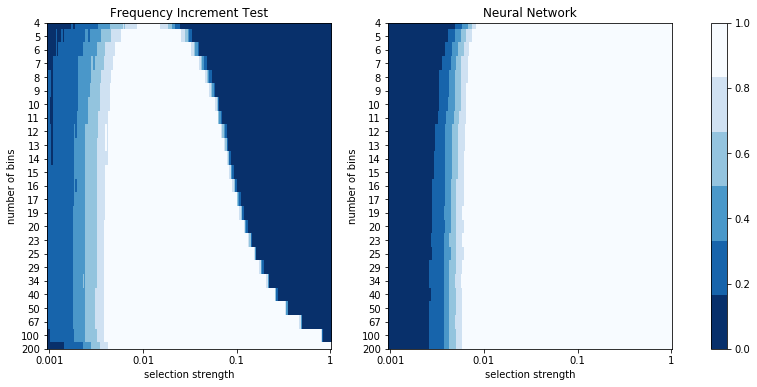

In [229]:
import matplotlib.pyplot as plt

def plot_heat(df, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = ax.imshow(
        df, aspect="auto", cmap=plt.cm.get_cmap('Blues_r', 6), vmin=0, vmax=1)
    
    # correct x-ticks
    ticks = np.exp(np.linspace(np.log(0.001), np.log(1), 4))
    locs = np.where(np.isin(selection_values, ticks))[0]
    ax.set_xticks(locs)
    ax.set_xticklabels([f'{s:.13g}' for s in ticks])
    
    # correct y-ticks
    ax.set_yticks(np.arange(bins.shape[0]))
    ax.set_yticklabels(bins)
    
    # Set labels
    ax.set(xlabel="selection strength", ylabel="number of bins", title=title)
    return ax, img

fig, (fit_ax, nn_ax) = plt.subplots(ncols=2, figsize=(14, 6))

F = fit_df.groupby(["selection", "bin"])["pred"].mean().unTstack().T
ax, img = plot_heat(F, ax=fit_ax, title="Frequency Increment Test")

F = nn_df.groupby(["selection", "bin"])["pred"].mean().unstack().T
ax, img = plot_heat(F, ax=nn_ax, title="Neural Network")

fig.colorbar(img, ax=(fit_ax, nn_ax))

plt.savefig("../plots/selection_over_bin.png", transparent=True, dpi=300)

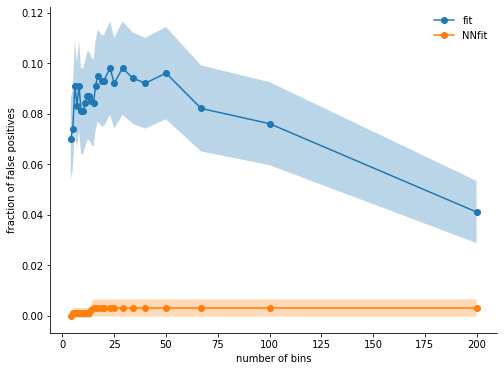

In [230]:
import scipy.stats as stats

def mean_confidence_interval(a):
    return stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=stats.sem(a))

def plot_bin_error(df, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = df.loc[df['selection'] == 0, ['bin', 'FP']].astype(
        int).groupby('bin')['FP'].agg(mean=np.mean, ci=mean_confidence_interval).values
    mean = x[:, 0]
    ci = np.array(x[:, 1].tolist())
    ax.plot(bins, mean, '-o', label=label)
    ax.fill_between(bins, ci[:, 0], ci[:, 1], alpha=0.3)
    ax.set(xlabel="number of bins", ylabel="fraction of false positives")
    return ax

fig, ax = plt.subplots(figsize=(8, 6))
plot_bin_error(fit_df, ax=ax, label="fit")
plot_bin_error(nn_df, ax=ax, label="NNfit")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False);
plt.savefig("../plots/FP-rate.png", dpi=300, transparent=True)

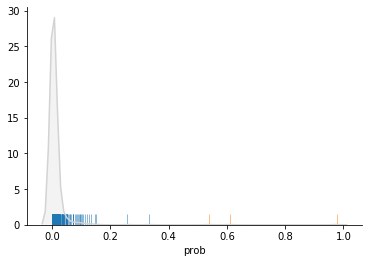

In [398]:
indexes = (nn_df['selection'] == 0) & (nn_df['bin'] == 20)
ax = sns.kdeplot(
    nn_df.loc[indexes, 'prob'], shade=True, color="lightgrey",
    label="__nolabel__"
)

sns.distplot(
    nn_df.loc[indexes & (nn_df['prob'] < 0.5), 'prob'], 
    rug=True, hist=False, kde=False, color="C0", rug_kws={"alpha": 0.5}
)

sns.distplot(
    nn_df.loc[indexes & (nn_df['prob'] > 0.5), 'prob'], 
    rug=True, hist=False, kde=False, color="C1", rug_kws={"alpha": 0.5}
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

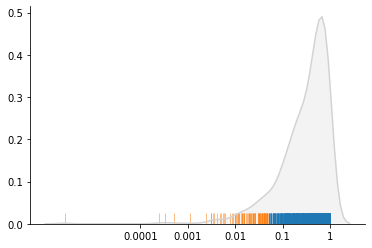

In [399]:
indexes = (fit_df['selection'] == 0) & (fit_df['bin'] == 20)
ax = sns.kdeplot(
    np.log(fit_df.loc[indexes, 'Tp']), 
    shade=True, color="lightgrey", label="__nolabel__"
)
ax.set_xticks(np.log([0.0001, 0.001, 0.01, 0.1, 1]))
ax.set_xticklabels([0.0001, 0.001, 0.01, 0.1, 1]);

sns.rugplot(
    np.log(fit_df.loc[indexes & (fit_df['Tp'] > 0.05), 'Tp']), 
    color="C0", alpha=0.5
)

sns.rugplot(
    np.log(fit_df.loc[indexes & (fit_df['Tp'] < 0.05), 'Tp']), 
    color="C1", alpha=0.5
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

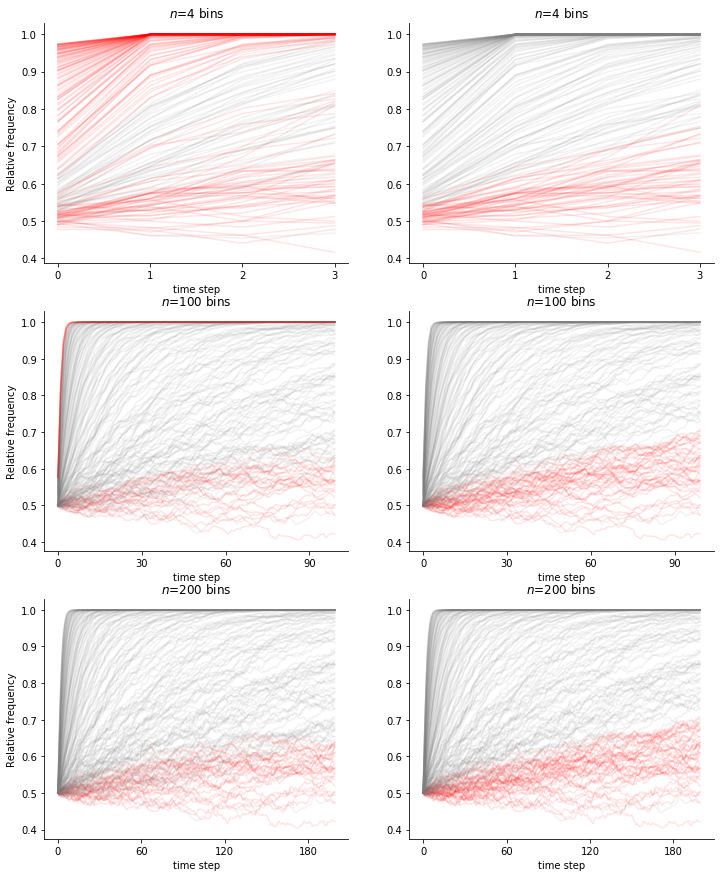

In [431]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 15))

for selection in selection_values:
    data = wright_fisher(n_agents, timesteps, selection, start=0.5)
    
    for i, bin_size in enumerate((4, 100, 200)):
        binned_data = apply_binning(data, bin_size, n_agents)
        fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        color = ('red' if (fit['Tp'] < 0.05 and selection == 0) else 
                 'red' if (selection > 0 and fit['Tp'] > 0.05) else
                 'grey')
        axes[i, 0].plot(binned_data, color=color, alpha=0.1)
        axes[i, 0].set_ylabel("Relative frequency")
        axes[i, 0].set_xlabel("time step")
        
        axes[i, 0].spines['top'].set_visible(False)
        axes[i, 0].spines['right'].set_visible(False)
        
        axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(4))
        axes[i, 0].set_title(f'$n$={bin_size} bins')
        
        with torch.no_grad():
            prob = torch.sigmoid(
                model(torch.FloatTensor([binned_data]).unsqueeze(1).to(device))
            ).cpu().numpy().squeeze(1)[0]
            pred = prob > 0.5
            color = ('red' if (pred and selection == 0) else 
                     'red' if (selection > 0 and not pred) else
                     'grey')
            axes[i, 1].plot(binned_data, color=color, alpha=0.1)
            axes[i, 1].set_xlabel("time step")
            
            axes[i, 1].spines['top'].set_visible(False)
            axes[i, 1].spines['right'].set_visible(False)
            
            axes[i, 1].xaxis.set_major_locator(plt.MaxNLocator(4))
            axes[i, 1].set_title(f'$n$={bin_size} bins')